In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

In [2]:
stats = pd.read_csv("features.csv")

In [5]:
data = stats[stats['TOTAL_seasons'] >= 3]
player_list = data['Player'].unique()

len(player_list) 

1136

In [6]:
from sklearn.model_selection import train_test_split

# Split players into training and test sets
train_players_list, test_players_list = train_test_split(player_list, random_state = 42)

print("training size: ", len(train_players_list))
print("testing size: ", len(test_players_list))

training size:  852
testing size:  284


In [7]:
def train_or_test(player):
    if player in train_players_list:
        return 'train'
    else:
        return 'test'

data['train_test'] = data['Player'].apply(train_or_test)

In [8]:
train = data[data['train_test'] == 'train']
test = data[data['train_test'] == 'test']

In [9]:
features = ['minutes_proportion', 'two_point_percentage', 'two_point_attempts', 'three_point_percentage',
              'three_point_attempts', 'free_throw_percentage','free_throw_attempts', 'defensive_rebounds',
              'offensive_rebounds', 'assists', 'steals', 'blocks', 'turnovers', 'personal_fouls']

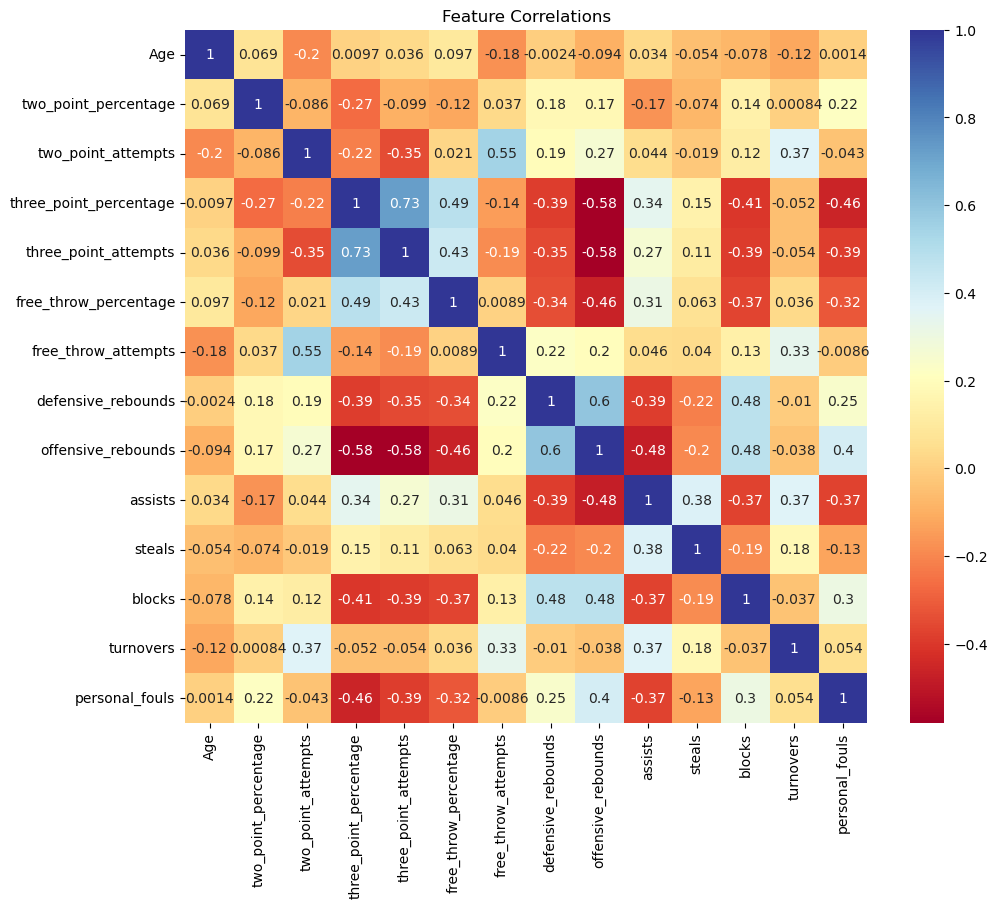

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

cfeatures =  ['Age', 'two_point_percentage', 'two_point_attempts', 'three_point_percentage',
              'three_point_attempts', 'free_throw_percentage','free_throw_attempts', 'defensive_rebounds',
              'offensive_rebounds', 'assists', 'steals', 'blocks', 'turnovers', 'personal_fouls']

plt.figure(figsize=(11,9))
plt.title('Feature Correlations')
sns.heatmap(data[cfeatures].corr(), annot = True, cmap = 'RdYlBu');

In [11]:
from collections import defaultdict

# For each feature identify strongly correlated features

corrs = data.corr()
corr_dict = defaultdict(list)

for feature in features:
    feat_corrs = corrs[feature]
    for feat, corr in zip(feat_corrs.index, feat_corrs.values):
        if np.abs(corr) > 0.2 and feat != feature and feat[-2] == 'p':
            corr_dict[feature].append((feat, corr))

for key in corr_dict.keys():
    corr_dict[key] = sorted(corr_dict[key], key=lambda tup: -tup[1])

In [12]:
def evaluate_general_model(model, X_data, y_data, sig = False, mae = True, r2 = False):
    
    preds = model.predict(X_data)
    
    if sig == True:
        preds = sigmoid(preds)
        y_data = sigmoid(y_data)
    
    if mae:
        return mean_absolute_error(y_data, preds)
    
    if r2 == False:
        return mean_squared_error(y_data, preds)
    
    else :
        return r2_score(y_data, preds)

In [13]:
from sklearn.linear_model import LinearRegression
lin_model = LinearRegression()

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold

from yellowbrick.model_selection import RFECV

In [16]:
targets = ['Age', 'Age2', 'Age3', 'two_point_percentage_p1', 'two_point_attempts_p1',
       'three_point_percentage_p1', 'three_point_attempts_p1',
       'free_throw_percentage_p1', 'free_throw_attempts_p1',
       'defensive_rebounds_p1', 'offensive_rebounds_p1', 'assists_p1',
       'steals_p1', 'blocks_p1', 'turnovers_p1', 'personal_fouls_p1']

In [17]:
X_train = train[train['season_index'] >= 1][targets]
y_train = train[train['season_index'] >= 1]['two_point_attempts']
X_test = test[test['season_index'] >= 1][targets]
y_test = test[test['season_index'] >= 1]['two_point_attempts']

In [19]:
pip install mapie

     ---------------------------------------- 98.7/98.7 kB 2.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [20]:
from mapie.regression import MapieRegressor

In [21]:
est = RandomForestRegressor(n_estimators=10)
mapie = MapieRegressor(est, cv=10, agg_function="median")
mapie.fit(X_train, y_train)
y_test_pred, y_test_pis = mapie.predict(X_test, alpha=[0.05])

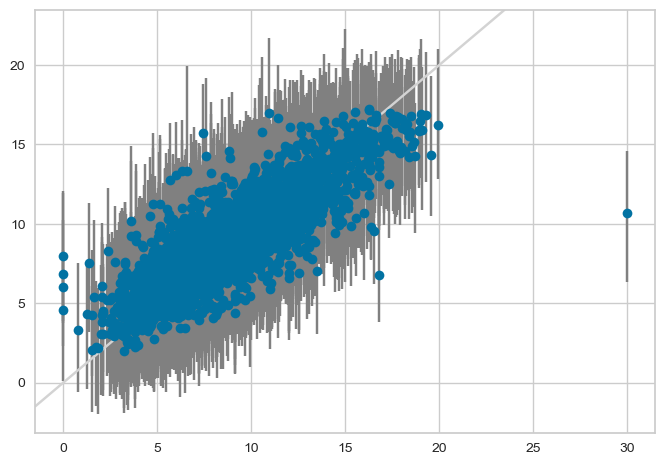

In [22]:
y_err = np.abs(y_test_pis[:, :, 0].T - y_test_pred)
plt.errorbar(y_test, y_test_pred, yerr=y_err, fmt="o", ecolor="gray", capsize=3)
plt.plot(plt.xlim(), plt.xlim(), color="lightgray", scalex=False, scaley=False)
plt.xlabel("Experiment")
plt.ylabel("Predicted")

In [25]:
from sklearn.metrics import make_scorer, mean_absolute_error
from mapie.metrics import regression_coverage_score
mae_test = mean_absolute_error(y_test, y_test_pred)
print(f"MAE: {mae_test:.3f}")
print(f"Width of 95% prediction interval: {np.mean(y_err) * 2:3f}")
coverage = regression_coverage_score(y_test, y_test_pis[:, 0, 0], y_test_pis[:, 1, 0])
print(f"Coverage: {coverage:.3f}")

MAE: 1.468
Width of 95% prediction interval: 8.257030
Coverage: 0.974


In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_error
import scipy.stats

MAE: 1.398
Width of 95% prediction interval: 7.967533
Coverage: 0.965


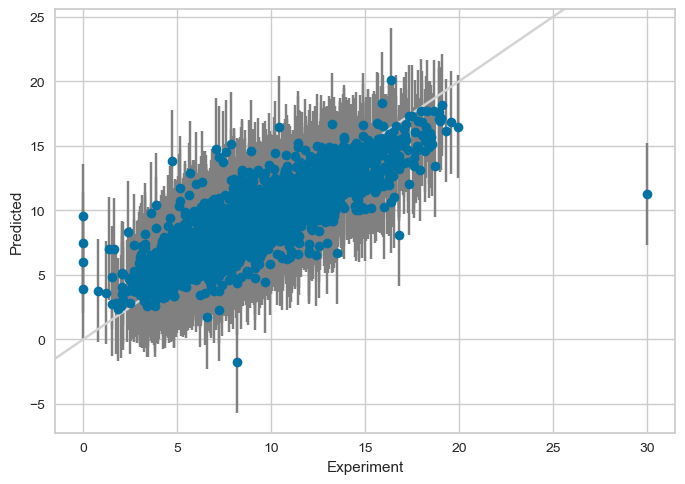

In [28]:
est = LinearRegression()
est.fit(X_train, y_train)
y_train_pred = est.predict(X_train)
y_test_pred = est.predict(X_test)

# Compute prediction intervals
sum_of_squares = np.sum((y_train - y_train_pred) ** 2)
std = np.sqrt(1 / (len(y_train) - 2) * sum_of_squares)

# Plot the prediction intervals
y_err = np.vstack([std, std]) * 1.96
plt.errorbar(y_test, y_test_pred, yerr=y_err, fmt="o", ecolor="gray", capsize=3)
plt.plot(plt.xlim(), plt.xlim(), color="lightgray", scalex=False, scaley=False)
plt.xlabel("Experiment")
plt.ylabel("Predicted")

# Print out statistics
mae_test = mean_absolute_error(y_test, y_test_pred)
print(f"MAE: {mae_test:.3f}")
print(f"Width of 95% prediction interval: {np.mean(y_err) * 2:3f}")
coverage = regression_coverage_score(
    y_test, y_test_pred - std * 1.96, y_test_pred + std * 1.96
)
print(f"Coverage: {coverage:.3f}")

MAE: 1.398
Width of 95% prediction interval: 5.627320
Coverage: 0.886


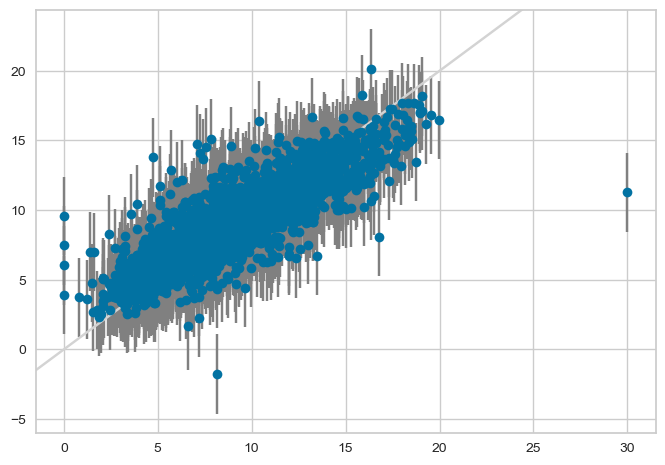

In [29]:
from sklearn.linear_model import BayesianRidge

# Fit model
est = BayesianRidge()
est.fit(X_train, y_train)
y_test_pred, y_test_std = est.predict(X_test, return_std=True)

# Plot the data with the error bars
y_err = np.vstack([y_test_std, y_test_std]) * 1.96 / 2
plt.errorbar(y_test, y_test_pred, yerr=y_err, fmt="o", ecolor="gray", capsize=3)
plt.plot(plt.xlim(), plt.xlim(), color="lightgray", scalex=False, scaley=False)
plt.xlabel("Experiment")
plt.ylabel("Predicted")

# Print out statistics
mae_test = mean_absolute_error(y_test, y_test_pred)
print(f"MAE: {mae_test:.3f}")
print(f"Width of 95% prediction interval: {np.mean(y_err) * 2:3f}")
coverage = regression_coverage_score(
    y_test, -y_err[0] + y_test_pred, y_err[1] + y_test_pred
)
print(f"Coverage: {coverage:.3f}")

MAE: 1.398
Width of 95% prediction interval: 7.522753
Coverage: 0.957


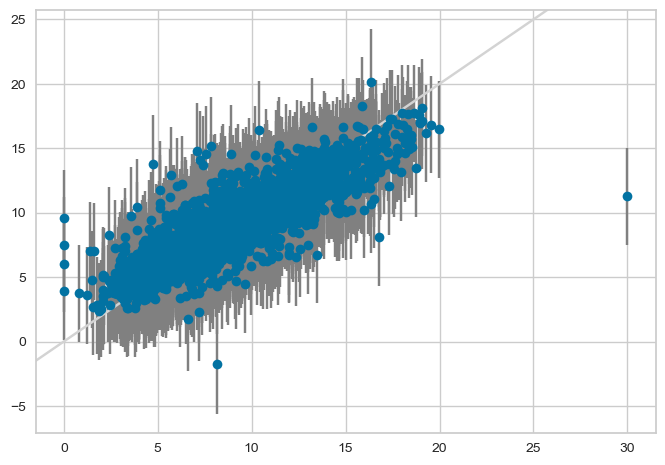

In [30]:
from mapie.regression import MapieRegressor

# Train model
est = LinearRegression()
mapie = MapieRegressor(est, cv=10, agg_function="median")
mapie.fit(X_train, y_train)
y_test_pred, y_test_pis = mapie.predict(X_test, alpha=[0.05])

# Plot the data with the error bars
y_err = np.abs(y_test_pis[:, :, 0].T - y_test_pred)
plt.errorbar(y_test, y_test_pred, yerr=y_err, fmt="o", ecolor="gray", capsize=3)
plt.plot(plt.xlim(), plt.xlim(), color="lightgray", scalex=False, scaley=False)
plt.xlabel("Experiment")
plt.ylabel("Predicted")

# Print out statistics
mae_test = mean_absolute_error(y_test, y_test_pred)
print(f"MAE: {mae_test:.3f}")
print(f"Width of 95% prediction interval: {np.mean(y_err) * 2:3f}")
coverage = regression_coverage_score(y_test, y_test_pis[:, 0, 0], y_test_pis[:, 1, 0])
print(f"Coverage: {coverage:.3f}")

In [33]:
from sklearn.feature_selection import RFECV
rfr = RandomForestRegressor(n_estimators=100)
select = RFECV(rfr, step=1, cv=5)
select = select.fit(X_train, y_train)
 
print("Feature ranking: ", select.ranking_)


Feature ranking:  [1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [34]:
from numpy import array 
mask = select.get_support()
features = array(X_train.columns.values)

In [37]:
best_features=features[mask]

In [38]:
print("All features: ", X_train.shape[1])
print(features)

print("Selected best: ", best_features.shape[0])
print(features[mask])

All features:  16
['Age' 'Age2' 'Age3' 'two_point_percentage_p1' 'two_point_attempts_p1'
 'three_point_percentage_p1' 'three_point_attempts_p1'
 'free_throw_percentage_p1' 'free_throw_attempts_p1'
 'defensive_rebounds_p1' 'offensive_rebounds_p1' 'assists_p1' 'steals_p1'
 'blocks_p1' 'turnovers_p1' 'personal_fouls_p1']
Selected best:  15
['Age' 'Age2' 'two_point_percentage_p1' 'two_point_attempts_p1'
 'three_point_percentage_p1' 'three_point_attempts_p1'
 'free_throw_percentage_p1' 'free_throw_attempts_p1'
 'defensive_rebounds_p1' 'offensive_rebounds_p1' 'assists_p1' 'steals_p1'
 'blocks_p1' 'turnovers_p1' 'personal_fouls_p1']


In [39]:
X_train = train[train['season_index'] >= 1][best_features]
y_train = train[train['season_index'] >= 1]['two_point_attempts']
X_test = test[test['season_index'] >= 1][best_features]
y_test = test[test['season_index'] >= 1]['two_point_attempts']


MAE: 1.466
Width of 95% prediction interval: 8.362651
Coverage: 0.977


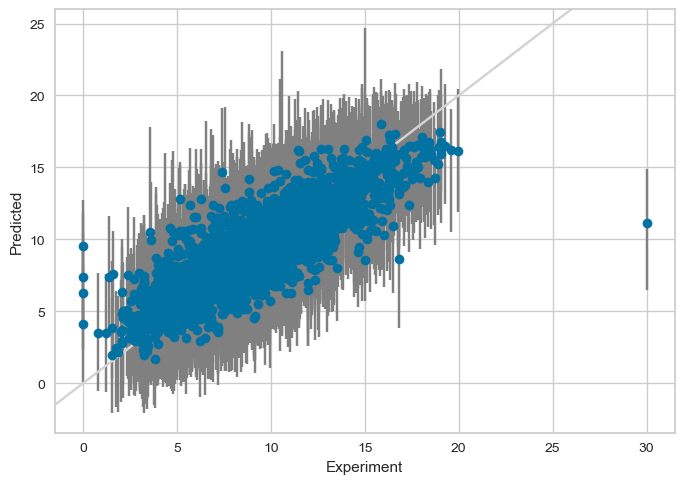

In [40]:
est = RandomForestRegressor(n_estimators=10)
mapie = MapieRegressor(est, cv=10, agg_function="median")
mapie.fit(X_train, y_train)
y_test_pred, y_test_pis = mapie.predict(X_test, alpha=[0.05])

y_err = np.abs(y_test_pis[:, :, 0].T - y_test_pred)
plt.errorbar(y_test, y_test_pred, yerr=y_err, fmt="o", ecolor="gray", capsize=3)
plt.plot(plt.xlim(), plt.xlim(), color="lightgray", scalex=False, scaley=False)
plt.xlabel("Experiment")
plt.ylabel("Predicted")

mae_test = mean_absolute_error(y_test, y_test_pred)
print(f"MAE: {mae_test:.3f}")
print(f"Width of 95% prediction interval: {np.mean(y_err) * 2:3f}")
coverage = regression_coverage_score(y_test, y_test_pis[:, 0, 0], y_test_pis[:, 1, 0])
print(f"Coverage: {coverage:.3f}")

In [ ]:
est = RandomForestRegressor(n_estimators=10)
mapie = MapieRegressor(est, cv=10, agg_function="median")
mapie.fit(X_train, y_train)
y_test_pred, y_test_pis = mapie.predict(X_test, alpha=[0.05])

y_err = np.abs(y_test_pis[:, :, 0].T - y_test_pred)
plt.errorbar(y_test, y_test_pred, yerr=y_err, fmt="o", ecolor="gray", capsize=3)
plt.plot(plt.xlim(), plt.xlim(), color="lightgray", scalex=False, scaley=False)
plt.xlabel("Experiment")
plt.ylabel("Predicted")

mae_test = mean_absolute_error(y_test, y_test_pred)
print(f"MAE: {mae_test:.3f}")
print(f"Width of 95% prediction interval: {np.mean(y_err) * 2:3f}")
coverage = regression_coverage_score(y_test, y_test_pis[:, 0, 0], y_test_pis[:, 1, 0])
print(f"Coverage: {coverage:.3f}")